This script analyze the data collected from NOAA and CARB in Pasadena during RECAP-2021 between Aug 7 ~ Sept 6, 2021.

In [2]:
import os, importlib, sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

sys.path.insert(0, '../../code/src')
#importlib.reload(sys.modules['extract_aqmd_data'])
from extract_aqmd_data import extract_ict_data

## PTR-MS data from NOAA

In [3]:
# get PTR-MS file ('_R1' as final version, 'cal' as calibrated species included)
foldpath = '../../data/raw/NOAA_PTR/'
filelist = [f for f in listdir(foldpath)\
             if f.endswith('_R1.ict') and 'cal' in f]

df_all = pd.DataFrame(columns=['Date_pdt', 'Parameter', 'Value'])
for i in range(len(filelist)):
    filepath = foldpath + filelist[i]
    #print(filepath)
    df = extract_ict_data(filepath)
    
    # store in one dataframe
    df_all = df_all.append(df)
df_all = df_all.replace(-9999, np.nan)
df_all['Date'] = pd.to_datetime(df_all['Date_pdt']).dt.date
df_all['Time'] = pd.to_datetime(df_all['Date_pdt']).dt.time
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday < 5,'Weekday'] = 'weekday'
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday >= 5,'Weekday'] = 'weekend'

# get daily average (morning)
df_all = df_all[df_all['Value']>0]
df_all = df_all[(df_all['Time']>=dt.time(10,0,0))&
                        (df_all['Time']<=dt.time(12,0,0))]
df_PTR_cal_avg = df_all.groupby(['Date','Parameter']).\
    agg({'Value':'mean','Weekday':'first'}).reset_index()

In [4]:
# get PTR-MS file ('_R1' as final version, 'all' as all species included)
foldpath = '../../data/raw/NOAA_PTR/'
filelist = [f for f in listdir(foldpath)\
             if f.endswith('_R1.ict') and 'all' in f]

df_all = pd.DataFrame(columns=['Date_pdt', 'Parameter', 'Value'])
for i in range(len(filelist)):
    filepath = foldpath + filelist[i]
    #print(filepath)
    df = extract_ict_data(filepath)
    
    # store in one dataframe
    df_all = df_all.append(df)
df_all = df_all.replace(-9999, np.nan)
df_all['Date'] = pd.to_datetime(df_all['Date_pdt']).dt.date
df_all['Time'] = pd.to_datetime(df_all['Date_pdt']).dt.time
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday < 5,'Weekday'] = 'weekday'
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday >= 5,'Weekday'] = 'weekend'

# get daily average (morning)
df_all = df_all[df_all['Value']>0]
df_all = df_all[(df_all['Time']>=dt.time(10,0,0))&
                        (df_all['Time']<=dt.time(12,0,0))]
df_PTR_all_avg = df_all.groupby(['Date','Parameter']).\
    agg({'Value':'mean','Weekday':'first'}).reset_index()

In [7]:
# replaced species with calibrated value
for i in df_PTR_cal_avg['Parameter'].unique():
    for j in df_PTR_cal_avg['Date'].unique():
        df_PTR_all_avg.loc[(df_PTR_all_avg['Parameter']==i)&(df_PTR_all_avg['Date']==j),
                           'Value'] = \
            df_PTR_cal_avg.loc[(df_PTR_cal_avg['Parameter']==i)&(df_PTR_cal_avg['Date']==j),
                                'Value'].iloc[0]

#df_PTR_all_avg.to_csv('../../data/intermediate/NOAA_PTR_morning_daily_avg.csv', index=False)

In [22]:
# prepare PTR SAPRC name list
df_PTR_species = df_PTR_all_avg.groupby('Parameter').agg({'Value':'mean'}).reset_index()
df_PTR_species = df_PTR_species[df_PTR_species['Value']>0.005]

df_name_saprc_PTR = pd.read_csv('../../data/raw/parameter_saprc_list_PTR_corrected.csv')
df_PTR_species = df_PTR_species.merge(df_name_saprc_PTR, how='left', left_on='Parameter', right_on='Name')
df_PTR_species = df_PTR_species[['Parameter_x','Name','Note','other name','S11','S11-2']]
df_PTR_species.to_csv('../../data/intermediate/parameter_saprc_list_PTR_corrected.csv', index=False)

## GC-MS from NOAA

In [5]:
# get GC-MS file
foldpath = '../../data/raw/NOAA_GCMS/'
filelist = [f for f in listdir(foldpath)]

df_all = pd.DataFrame(columns=['Date_pdt', 'Parameter', 'Value'])
for i in range(len(filelist)):
    filepath = foldpath + filelist[i]
    #print(filepath)
    df = extract_ict_data(filepath)
    
    # store in one dataframe
    df_all = df_all.append(df)
df_all = df_all.replace(-9999, np.nan)
df_all['Date'] = pd.to_datetime(df_all['Date_pdt']).dt.date
df_all['Time'] = pd.to_datetime(df_all['Date_pdt']).dt.time
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday < 5,'Weekday'] = 'weekday'
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday >= 5,'Weekday'] = 'weekend'

# get daily average (morning)
df_all = df_all[df_all['Value']>0]
df_all = df_all[(df_all['Time']>=dt.time(10,0,0))&
                        (df_all['Time']<=dt.time(12,0,0))]
df_GCMS_all_avg = df_all.groupby(['Date','Parameter']).\
    agg({'Value':'mean','Weekday':'first'}).reset_index()

#df_GCMS_all_avg.to_csv('../../data/intermediate/NOAA_GCMS_morning_daily_avg.csv',
#                        index=False)

## NOAA NOxNOyO3

In [8]:
foldpath = '../../data/raw/NOAA_NOxNOyO3/'
filelist = [f for f in listdir(foldpath)]

df_all = pd.DataFrame(columns=['Date_pdt', 'Parameter', 'Value'])
for i in range(len(filelist)):
    filepath = foldpath + filelist[i]
    #print(filepath)
    df = extract_ict_data(filepath)
    
    # store in one dataframe
    df_all = df_all.append(df)
df_all = df_all.replace(-9999, np.nan)
df_all['Date'] = pd.to_datetime(df_all['Date_pdt']).dt.date
df_all['Time'] = pd.to_datetime(df_all['Date_pdt']).dt.time
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday < 5,'Weekday'] = 'weekday'
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday >= 5,'Weekday'] = 'weekend'

# get daily average (morning)
df_all = df_all[df_all['Value']>0]
df_all = df_all[(df_all['Time']>=dt.time(10,0,0))&
                        (df_all['Time']<=dt.time(12,0,0))]
df_NOxNOyO3_all_avg = df_all.groupby(['Date','Parameter']).\
    agg({'Value':'mean','Weekday':'first'}).reset_index()

#df_NOxNOyO3_all_avg.to_csv('../../data/intermediate/NOAA_NOxNOyO3_morning_daily_avg.csv',
#                           index=False)

#### Get NOx time series on Peak NOx day as quality check

In [2]:
from extract_aqmd_data import get_hourly_aqmd
df_NOx_aqmd = get_hourly_aqmd('../../data/raw/AQMD/NOX_PICKDATA_2021-12-31_PA.csv')

# convert number of Hour to pd.datetime
df_NOx_aqmd['Datetime'] = pd.to_datetime(df_NOx_aqmd['Date'].dt.strftime('%Y%m%d') + 
                                         df_NOx_aqmd['Hour'].astype('int').astype('str'),
                                         format='%Y%m%d%H') + pd.Timedelta(hours=0.5)

c:\Users\Shenglun\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


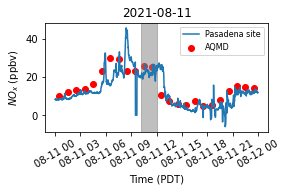

In [5]:
df_plot = df_all[(df_all['Date']==pd.to_datetime('2021-08-11'))&
                 (df_all['Parameter'].isin(['NO2_ppbv','NO_ppbv']))].\
    groupby('Date_pdt').agg({'Time':'first','Value':'sum'}).reset_index()
df_aqmd = df_NOx_aqmd[df_NOx_aqmd['Date']=='2021-08-11']

fig, ax=plt.subplots(figsize=(4,2))
ax.plot(pd.to_datetime(df_plot['Date_pdt']), df_plot['Value'], label='Pasadena site')
ax.scatter(df_aqmd['Datetime'], df_aqmd['Value']*1000, label='AQMD', color='red')

ax.legend(loc='upper right', fontsize=8)
plt.xticks(rotation=30)
# add shaded area between 10AM and 12PM
ax.axvspan(pd.to_datetime('2021-08-11 10:10:00'), pd.to_datetime('2021-08-11 12:00:00'), 
           alpha=0.5, color='grey')

ax.set_xlabel('Time (PDT)')
ax.set_ylabel('$NO_x$ (ppbv)')
ax.set_title('2021-08-11')
fig.savefig('../../result/time_series_NOx_check_2021-08-11.png', dpi=1200, bbox_inches='tight', facecolor='white')

c:\Users\Shenglun\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


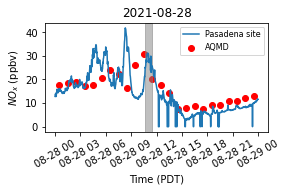

In [6]:
df_plot = df_all[(df_all['Date']==pd.to_datetime('2021-08-28'))&
                 (df_all['Parameter'].isin(['NO2_ppbv','NO_ppbv']))].\
    groupby('Date_pdt').agg({'Time':'first','Value':'sum'}).reset_index()
df_aqmd = df_NOx_aqmd[df_NOx_aqmd['Date']=='2021-08-28']

fig, ax=plt.subplots(figsize=(4,2))
ax.plot(pd.to_datetime(df_plot['Date_pdt']), df_plot['Value'], label='Pasadena site')
ax.scatter(df_aqmd['Datetime'], df_aqmd['Value']*1000, label='AQMD', color='red')

ax.legend(loc='upper right', fontsize=8)
plt.xticks(rotation=30)
# add shaded area between 10AM and 12PM
ax.axvspan(pd.to_datetime('2021-08-28 10:40:00'), pd.to_datetime('2021-08-28 11:30:00'), 
           alpha=0.5, color='grey')

ax.set_xlabel('Time (PDT)')
ax.set_ylabel('$NO_x$ (ppbv)')
ax.set_title('2021-08-28')
#fig.savefig('../../result/time_series_NOx_check_2021-08-28.png', dpi=1200, bbox_inches='tight', facecolor='white')

## NOAA ICIMS

In [6]:
foldpath = '../../data/raw/NOAA_ICIMS/'
filelist = [f for f in listdir(foldpath)]

df_all = pd.DataFrame(columns=['Date_pdt', 'Parameter', 'Value'])
for i in range(len(filelist)):
    filepath = foldpath + filelist[i]
    #print(filepath)
    df = extract_ict_data(filepath)
    df.loc[:,'Value'] = df.loc[:,'Value']/1000 # convert from pptv to ppbv
    
    # store in one dataframe
    df_all = df_all.append(df)
df_all = df_all.replace(-9999, np.nan)
df_all['Date'] = pd.to_datetime(df_all['Date_pdt']).dt.date
df_all['Time'] = pd.to_datetime(df_all['Date_pdt']).dt.time
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday < 5,'Weekday'] = 'weekday'
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday >= 5,'Weekday'] = 'weekend'

# get daily average (morning)
df_all = df_all[df_all['Value']>0]
df_all = df_all[(df_all['Time']>=dt.time(10,0,0))&
                        (df_all['Time']<=dt.time(12,0,0))]
df_ICIMS_all_avg = df_all.groupby(['Date','Parameter']).\
    agg({'Value':'mean','Weekday':'first'}).reset_index()


#df_ICIMS_all_avg.to_csv('../../data/intermediate/NOAA_ICIMS_morning_daily_avg.csv',
#                        index=False)

## CARB PICARRO

In [7]:
foldpath = '../../data/raw/CARB_PICARRO/'
filelist = [f for f in listdir(foldpath)]

df_all = pd.DataFrame(columns=['Date_pdt', 'Parameter', 'Value'])
for i in range(len(filelist)):
    filepath = foldpath + filelist[i]
    #print(filepath)
    df = extract_ict_data(filepath)
    
    # store in one dataframe
    df_all = df_all.append(df)
df_all = df_all.replace(-9999, np.nan)
df_all['Date'] = pd.to_datetime(df_all['Date_pdt']).dt.date
df_all['Time'] = pd.to_datetime(df_all['Date_pdt']).dt.time
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday < 5,'Weekday'] = 'weekday'
df_all.loc[pd.to_datetime(df_all['Date_pdt']).dt.weekday >= 5,'Weekday'] = 'weekend'

# get daily average (morning)
df_all = df_all[df_all['Parameter'].isin(['CH4', 'CO', 'CO2','HCHO','NH3'])]
df_all.loc[df_all['Parameter'].isin(['CO','CH4','CO2']), 'Value'] = \
    df_all.loc[df_all['Parameter'].isin(['CO','CH4','CO2']), 'Value']*1000 # convert from ppmv to ppbv 
df_all = df_all[df_all['Value']>0]
df_all = df_all[(df_all['Time']>=dt.time(10,0,0))&
                        (df_all['Time']<=dt.time(12,0,0))]
df_PICARRO_all_avg = df_all.groupby(['Date','Parameter']).\
    agg({'Value':'mean','Weekday':'first'}).reset_index()

#df_PICARRO_all_avg.to_csv('../../data/intermediate/CARB_PICARRO_morning_daily_avg.csv',
#                        index=False)

## Transfer measured data to SAPRC11 categories

In [37]:
# delete repeat species in GCMS and PTR
df_PTR_daily = df_PTR_all_avg

df_GCMS_daily = df_GCMS_all_avg[~(df_GCMS_all_avg['Parameter'].str.contains('Pentene')|
                                df_GCMS_all_avg['Parameter'].str.contains('Benzene')|
                                df_GCMS_all_avg['Parameter'].str.contains('Isoprene')|
                                df_GCMS_all_avg['Parameter'].str.contains('MEK')|
                                df_GCMS_all_avg['Parameter'].str.contains('Toluene')|
                                df_GCMS_all_avg['Parameter'].str.contains('MeAcetate')|
                                df_GCMS_all_avg['Parameter'].str.contains('EthylAcetate')    ]

df_PICARRO_daily = df_PICARRO_all_avg
df_NOxNOyO3_daily = df_NOxNOyO3_all_avg
df_ICIMS_daily = df_ICIMS_all_avg

#### Get SAPRC11 categories for every measured species

In [10]:
# NOxNOyO3
df_name_saprc_NOxNOyO3 = df_NOxNOyO3_all_avg.groupby('Parameter').agg({'Value':'mean'}).reset_index()
df_name_saprc_NOxNOyO3['S11'] = ['NO2','NO','NaN','NaN','O3','NaN']
df_name_saprc_NOxNOyO3 = df_name_saprc_NOxNOyO3.drop(columns=['Value'])

# ICIMS
df_name_saprc_ICIMS = df_ICIMS_all_avg.groupby('Parameter').agg({'Value':'mean'}).reset_index()
df_name_saprc_ICIMS['S11'] = ['PAN2','CLNO2','HCOOH','HNO2','HNO3','N2O5','PAN','PAN2']
df_name_saprc_ICIMS = df_name_saprc_ICIMS.drop(columns=['Value'])

# PICARRO
df_name_saprc_PICARRO = df_PICARRO_all_avg.groupby('Parameter').agg({'Value':'mean'}).reset_index()
df_name_saprc_PICARRO['S11'] = ['CH4','CO','CO2','HCHO','NH3']
df_name_saprc_PICARRO = df_name_saprc_PICARRO.drop(columns=['Value'])

# PTR
df_name_saprc_PTR = pd.read_csv('../../data/intermediate/parameter_saprc_list_PTR_corrected.csv')

# GC-MS
df_name_saprc_GCMS = pd.read_csv('../../data/raw/parameter_saprc_list_GCMS.csv')

#### Merge SAPRC11 name to df_daily

In [39]:
# PICARRO
df_PICARRO_saprc = df_PICARRO_daily.merge(df_name_saprc_PICARRO, 
                                          left_on='Parameter',right_on='Parameter', how='left')

# NOxNOyO3
df_NOxNOyO3_saprc = df_NOxNOyO3_daily.merge(df_name_saprc_NOxNOyO3,
                                            left_on='Parameter',right_on='Parameter', how='left')

# ICIMS
df_ICIMS_saprc = df_ICIMS_daily.merge(df_name_saprc_ICIMS, 
                                      left_on='Parameter',right_on='Parameter', how='left')

# PTR
df_PTR_saprc = df_PTR_daily.merge(df_name_saprc_PTR.loc[:,['Name','S11']], 
                                  left_on='Parameter', right_on='Name', how='left')
df_PTR_saprc = df_PTR_saprc.drop(columns=['Name'])

#GC-MS
df_GCMS_saprc = df_GCMS_daily.merge(df_name_saprc_GCMS.loc[:,['Name','S11']], 
                                    left_on='Parameter', right_on='Name', how='left')
df_GCMS_saprc = df_GCMS_saprc.drop(columns=['Name'])

In [40]:
# combine all data together and sum up the daily concentration of  all species by SAPRC11 categories
df_all_saprc = pd.concat([df_PTR_saprc,df_GCMS_saprc,df_PICARRO_saprc,
                          df_NOxNOyO3_saprc,df_ICIMS_saprc])
df_all_saprc = df_all_saprc.groupby(['Date','S11']).\
    agg({'Value':'sum', 'Weekday':'first'}).reset_index()

# rename species used in chamber model
df_all_saprc.loc[df_all_saprc['S11']=='MeOH', 'S11'] = 'MEOH'
df_all_saprc.loc[df_all_saprc['S11']=='HNO2', 'S11'] = 'HNO4'

df_all_saprc.to_csv('../../data/intermediate/saprc11_initial_conc_pasadena.csv',
                    index=False)

# get VOC stats list

In [70]:
# get stats of all species
df_PTR_list = df_PTR_all_avg[df_PTR_all_avg['Parameter'].isin(df_name_saprc_PTR['Name'])].\
    groupby('Parameter').agg({'Value':['min','max','mean','std','median']}).reset_index()

# add SPAPRC group to species and only keep species needed in SAPRC11
df_PTR_list = df_PTR_list.merge(df_name_saprc_PTR[['Name','S11']], left_on='Parameter', right_on='Name', how='left')
df_PTR_list = df_PTR_list.iloc[:,1:]
df_PTR_list.columns = ['min','max','mean','std','median','Parameter','SAPRC']

c:\Users\Shenglun\anaconda3\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


In [92]:
# get PTR species name and chemical group

filepath = '../../data/raw/NOAA_PTR/recap-NOAAPTR-VOCs-all_CITN_20210807_R1.ict'

# get PTR spcies list and their formula
with open(filepath) as fp:
    content = fp.readlines()
lines = content[14:316]
df = pd.DataFrame({'Lines':lines})
df = df['Lines'].str.split(', ', 3, expand=True)
df.columns = ['Parameter','Unit','Note','Species']
df['Species'] = df['Species'].str.replace('\n','')
df[['Formula','Name']] = df['Species'].str.split(' ', 1, expand=True)
df['Formula'] = df['Formula'].str.replace('(','').str.replace(')','')
df = df[['Parameter','Note','Formula','Name']]

# only left species that are in SAPRC list
df = df[df['Parameter'].isin(df_name_saprc_PTR['Name'])]


# sign chemical groups to species
df['Group'] = np.nan

df.loc[df['Formula'].str.contains('F') |
       df['Formula'].str.contains('Cl') |
       df['Formula'].str.contains('Br'), 'Group'] = 'Halogenatics'

df.loc[df['Formula'].str.contains('O') &
       df['Formula'].str.contains('C') &
       df['Formula'].str.contains('H') &
       ~df['Formula'].str.contains('S') & 
       df['Group'].isna(), 'Group'] = 'OVOCs'

df.loc[df['Group'].isna() &
   df['Formula'].str.contains('N'), 'Group'] = 'Others' 

C:\Users\Shenglun\AppData\Local\Temp/ipykernel_6532/3118323447.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Formula'] = df['Formula'].str.replace('(','').str.replace(')','')


In [96]:
df_PTR_stat = df_PTR_list.merge(df, on='Parameter', how='left')#
df_PTR_stat.sort_values(by=['Group','Formula']).to_csv('../../data/intermediate/PTR_species_list.csv',index=False)
